In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
sns.set()

In [2]:
#import warnings
#warnings.filterwarnings("ignore")

In [3]:
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data.index = pd.DatetimeIndex(data.index.values, freq = data.index.inferred_freq)

First, we need to choose the signal we want to process and make it stationary using the differences between consecutive observations.

In [4]:
names = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']

# function that we use to make the signal stationary (we lose the first observation)
def difference(orig_series):
    diff = list()
    for i in range(1, len(orig_series)):
        value = orig_series.iloc[i] - orig_series.iloc[i - 1]
        diff.append(value)
    return pd.Series(diff, orig_series.index[1:])

In [5]:
signals = {} # signals we want to model with ARMA
for name in names:
    series = pd.Series(data[name], data.index)
    signals[name] = series
    display(series.head(5))

2014-01-06 00:00:00    0.509730
2014-01-06 01:00:00    0.412580
2014-01-06 02:00:00    0.320112
2014-01-06 03:00:00    0.332879
2014-01-06 04:00:00    0.483496
Freq: H, Name: L_T1, dtype: float64

2014-01-06 00:00:00    2.049003
2014-01-06 01:00:00    2.009072
2014-01-06 02:00:00    1.986093
2014-01-06 03:00:00    2.009203
2014-01-06 04:00:00    2.089049
Freq: H, Name: L_T2, dtype: float64

2014-01-06 00:00:00    3.191145
2014-01-06 01:00:00    3.642565
2014-01-06 02:00:00    4.140192
2014-01-06 03:00:00    4.673478
2014-01-06 04:00:00    5.237937
Freq: H, Name: L_T3, dtype: float64

2014-01-06 00:00:00    2.792634
2014-01-06 01:00:00    2.831673
2014-01-06 02:00:00    3.256733
2014-01-06 03:00:00    3.744497
2014-01-06 04:00:00    4.409456
Freq: H, Name: L_T4, dtype: float64

2014-01-06 00:00:00    2.656091
2014-01-06 01:00:00    3.126387
2014-01-06 02:00:00    3.574601
2014-01-06 03:00:00    3.952379
2014-01-06 04:00:00    3.504676
Freq: H, Name: L_T5, dtype: float64

2014-01-06 00:00:00    5.316831
2014-01-06 01:00:00    5.494855
2014-01-06 02:00:00    5.500000
2014-01-06 03:00:00    5.500000
2014-01-06 04:00:00    5.500000
Freq: H, Name: L_T6, dtype: float64

2014-01-06 00:00:00    1.562321
2014-01-06 01:00:00    1.852043
2014-01-06 02:00:00    2.246126
2014-01-06 03:00:00    3.203573
2014-01-06 04:00:00    4.439714
Freq: H, Name: L_T7, dtype: float64



Processing signal 'L_T1'


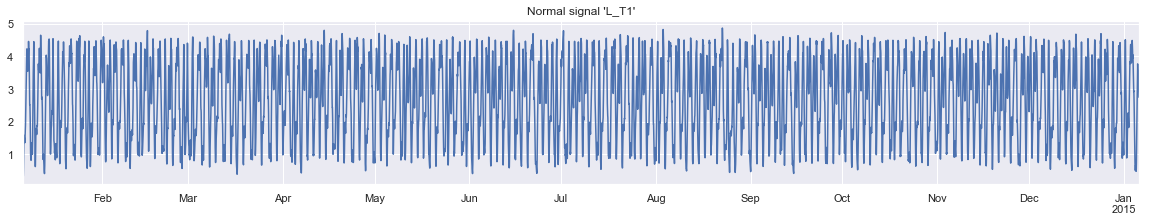

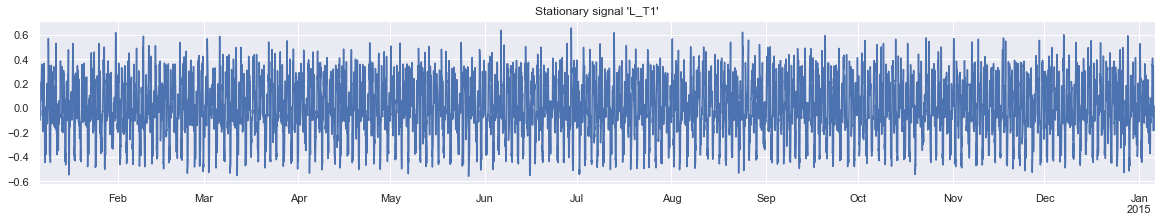



Processing signal 'L_T2'


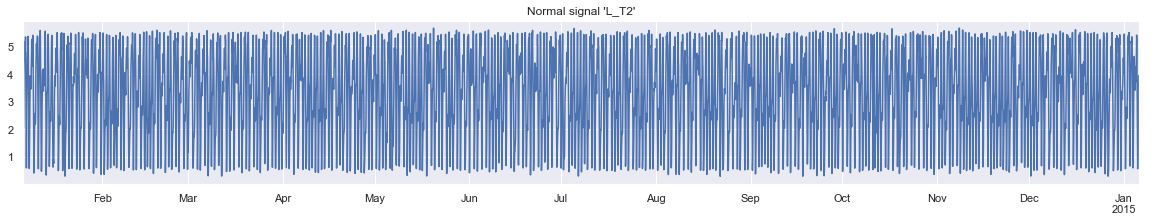

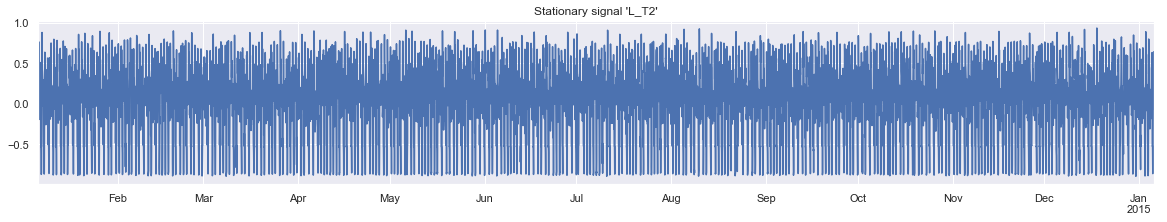



Processing signal 'L_T3'


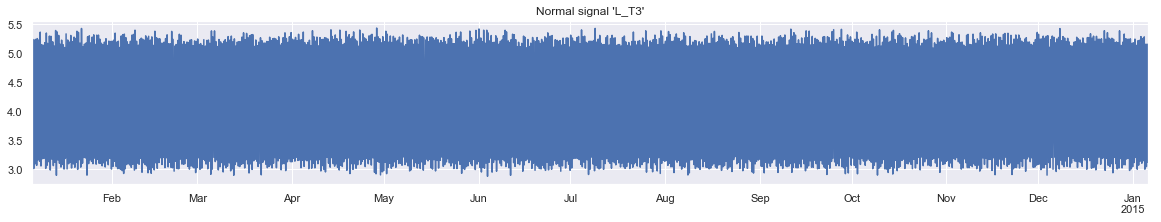

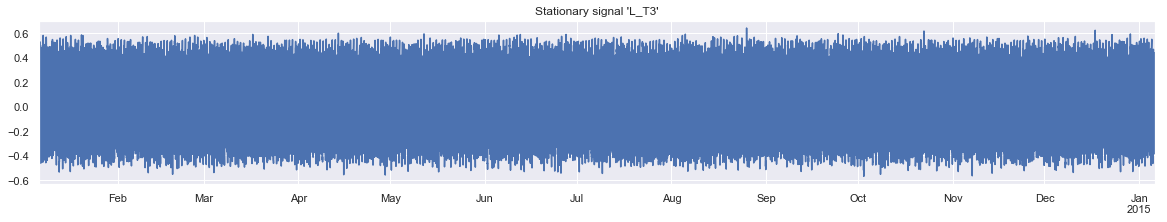



Processing signal 'L_T4'


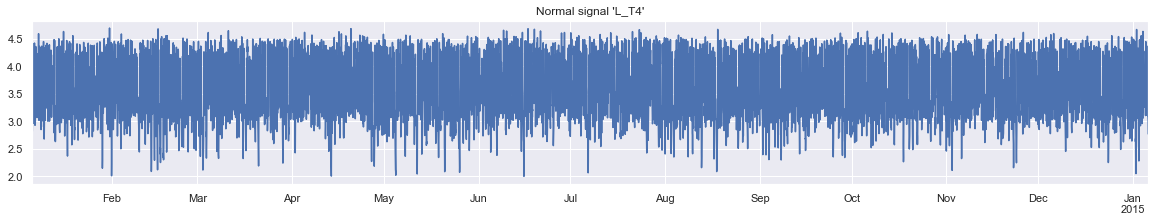

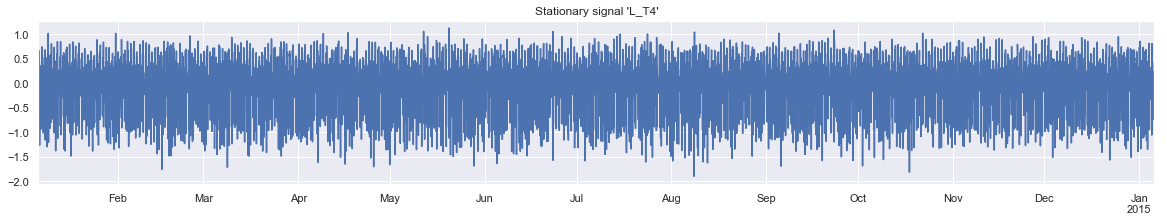



Processing signal 'L_T5'


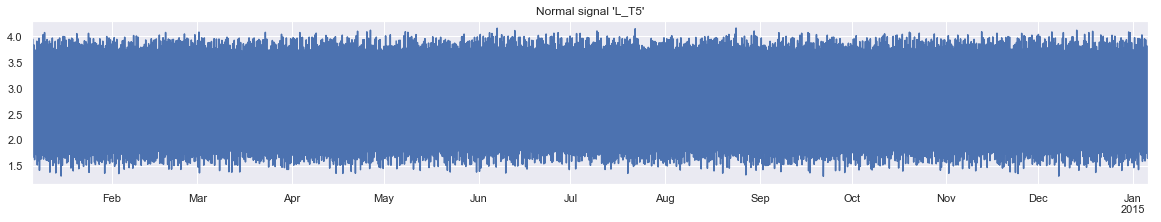

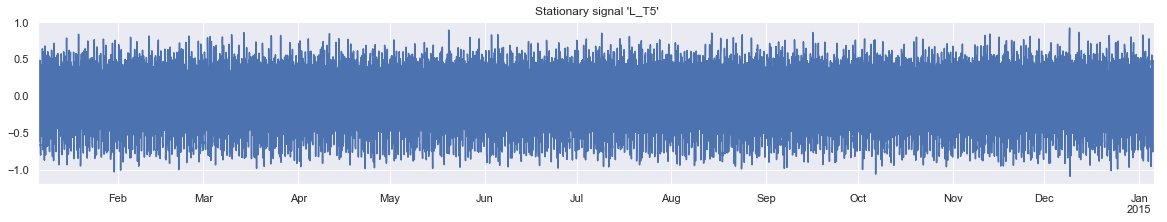



Processing signal 'L_T6'


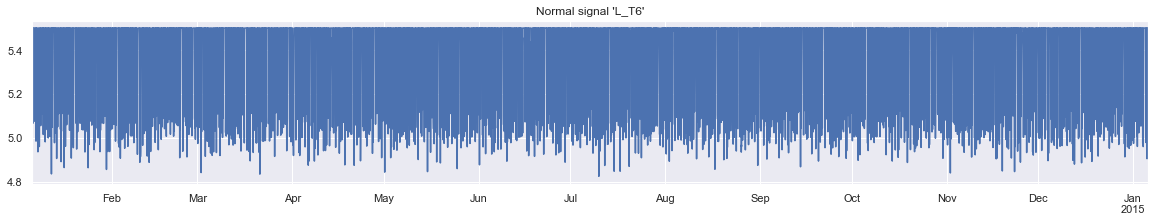

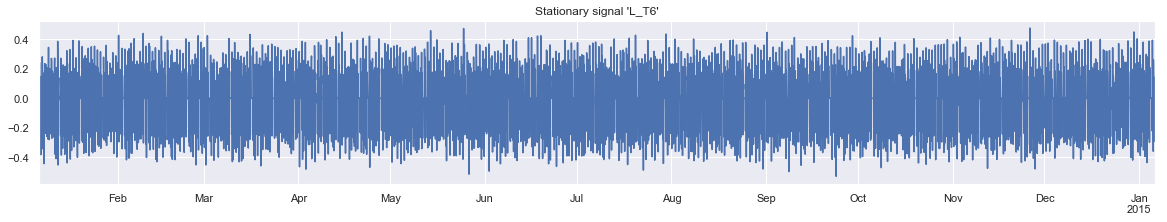



Processing signal 'L_T7'


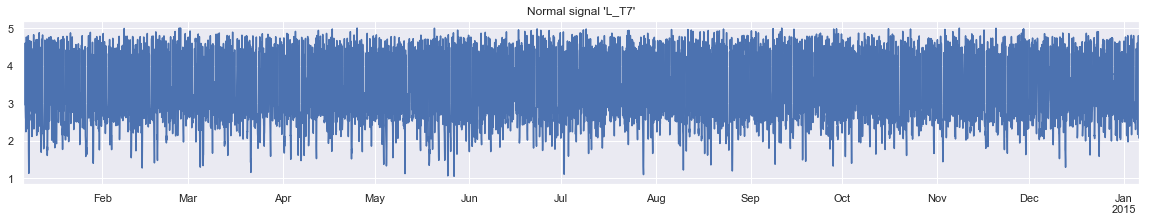

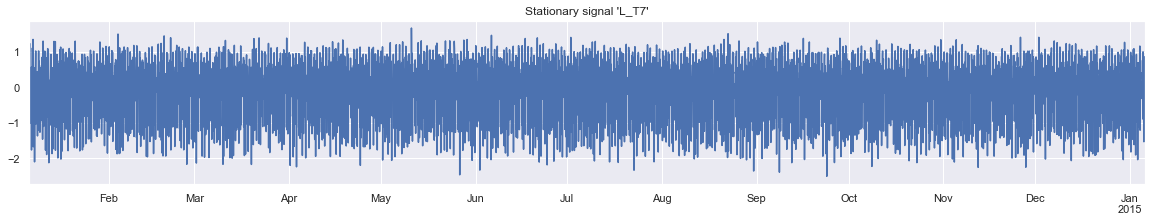

In [6]:
for signal in signals.keys():
    print(f"\n\nProcessing signal '{signal}'")
    
    series = signals[signal]
    
    # visualize it
    series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{signal}'")
    plt.show()
    
    stationary = difference(series)

    # visualize it
    stationary.plot(figsize=(20,3))
    plt.title(f"Stationary signal '{signal}'")
    plt.show()
              
    signals[signal] = stationary

### Plot ACF and PACF of the signal, to retrieve the values of p and q of the ARMA



Computing ACF and PACF for 'L_T1'


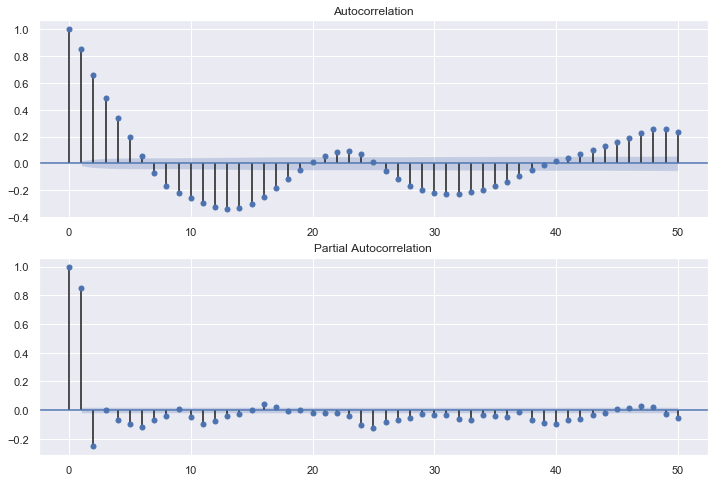



Computing ACF and PACF for 'L_T2'


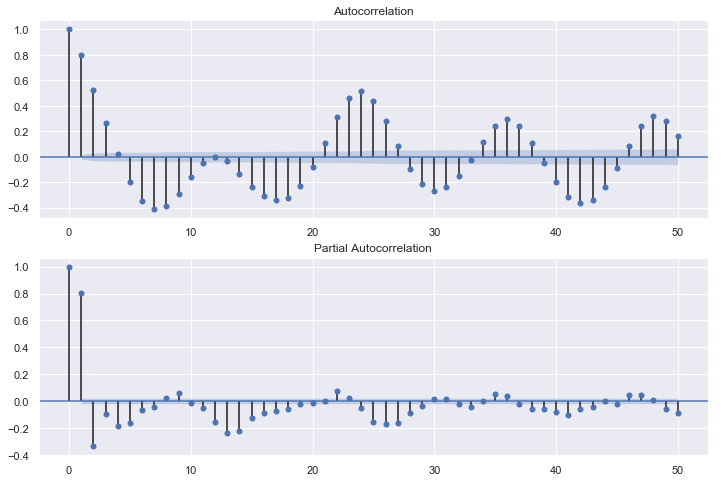



Computing ACF and PACF for 'L_T3'


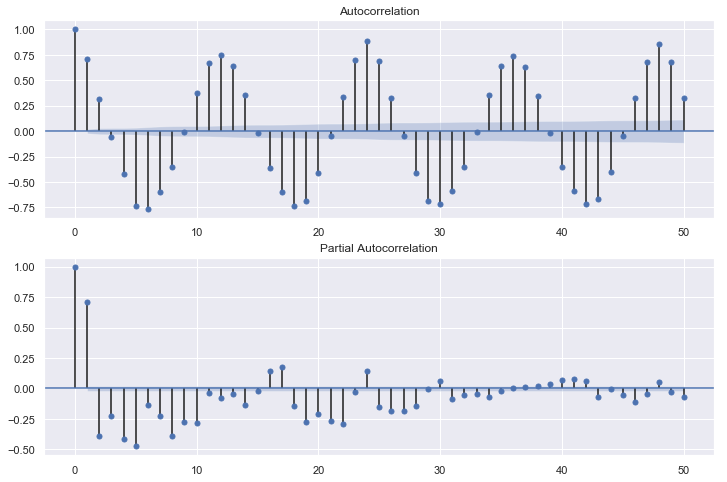



Computing ACF and PACF for 'L_T4'


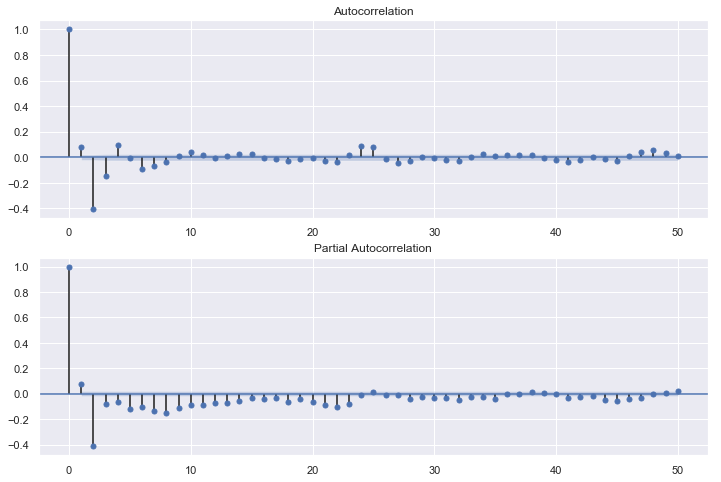



Computing ACF and PACF for 'L_T5'


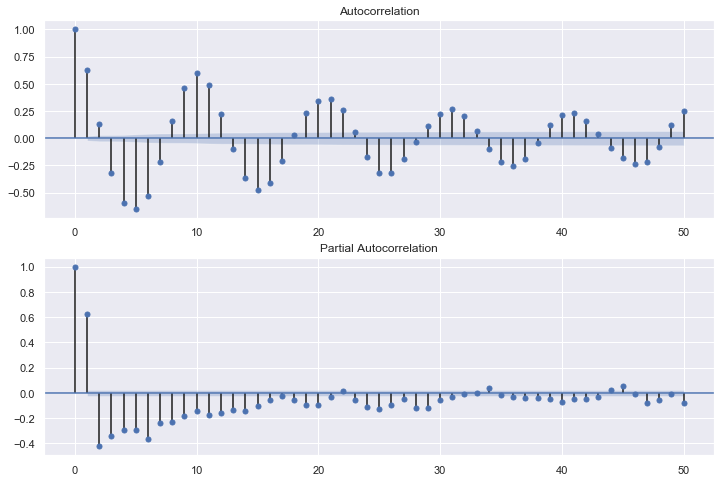



Computing ACF and PACF for 'L_T6'


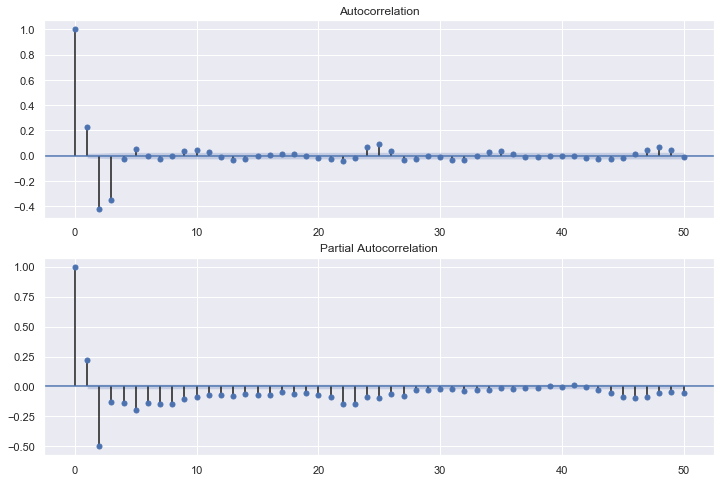



Computing ACF and PACF for 'L_T7'


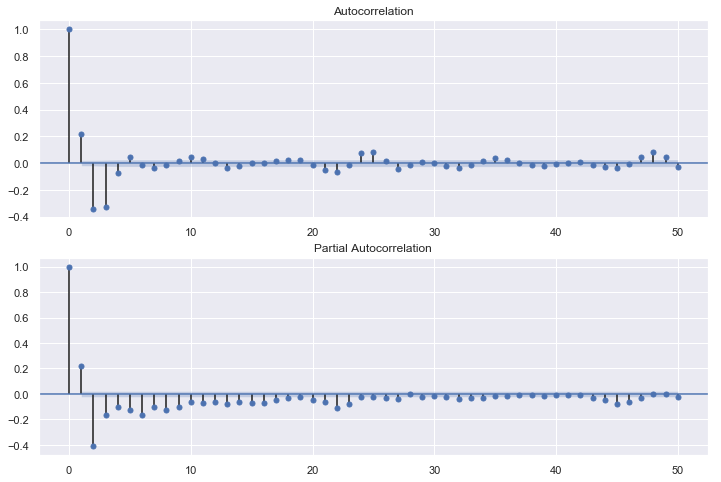

In [7]:
for signal in signals.keys():
    print(f"\n\nComputing ACF and PACF for '{signal}'")
    
    series = signals[signal]
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=50, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)
    plt.show()

By looking at the plot, we should choose p=1 and q=1 for all the 7 signals.

## Grid Search

In [8]:
import warnings
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [9]:
# import warnings
# warnings.filterwarnings("ignore")

Now we can define a function for evaluating the different parameters for the ARMA model

In [10]:
#resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_arima_model_mse(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    error = np.mean(aics)
    return error

def evaluate_arima_model_aic(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit(disp=0)
    return model_fit.aic

Now we define a method that loops over different sets of parameters for ARMA and evaluates the performance based on AIC.

In [11]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    #error = evaluate_arima_model_mse(dataset, order)
                    error = evaluate_arima_model_aic(dataset, order)
                    if error < best_score:
                        best_score, best_cfg = error, order
                    #print('ARIMA%s MSE=%.3f' % (order,error))
                    print('ARIMA%s AIC=%.3f' % (order,error))
                except:
                    continue # the try/catch is done because the optimization can fail: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
    #print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [12]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4]
d_values = [0] # no I component --> we only want ARMA and not ARIMA
q_values = range(0, 3)
warnings.filterwarnings("ignore")

# this TAKES A LOT, run it only if you really really really want to
# for signal in signals.keys():
#     print(f"\n\nComputing AIC values for '{signal}'")    
#     series = signals[signal]
#     evaluate_models(series.values, p_values, d_values, q_values)

Based on the results of ACF and PACF we should use q=1 and p=1. However, because of the way AIC works, it is likely to select a very complex model when testing too many models (). This is the case, where AIC suggests us to select the most complex model.    

If we look carefully to the values of AIC, though, we can see how there is a big drop when 'q' goes from 0 to 1. After this moment, the value of AIC goes down very slowly, suggesting that the added value of using a more complex parameter is not significant.   

For this reason, following the Occam's razor approach, we select q=1 and p=1, as it was initially suggested by the ACF and PACF plots. (Note: we select q=1 because it is specifically required in the assignment to fit an ARMA model. However, the different between q = 0 or 1 is not significant in the AIC).

In [13]:
order = (1, 0, 1) # as motivated before :)

In [14]:
# https://github.com/statsmodels/statsmodels/issues/2788 SARIMAX is needed to include new observations in time
def make_predictions_sarimax(trn_series, tst_series, order):
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    start_idx = tst_series.index[0]
    
    for tst_idx in tst_series.index:
        mod_tst = sm.tsa.SARIMAX(tst_series[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        
    return predictions
    

We choose training set 1 to fit our ARMA. This is because there are no attacks in this training set --> we can learn the normal behaviour

Predicting and plotting prediction for 'L_T1'


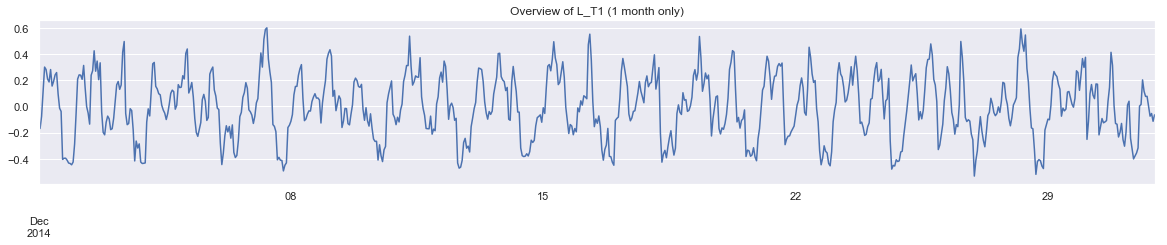

7752 hours used for training, 1008 for testing.


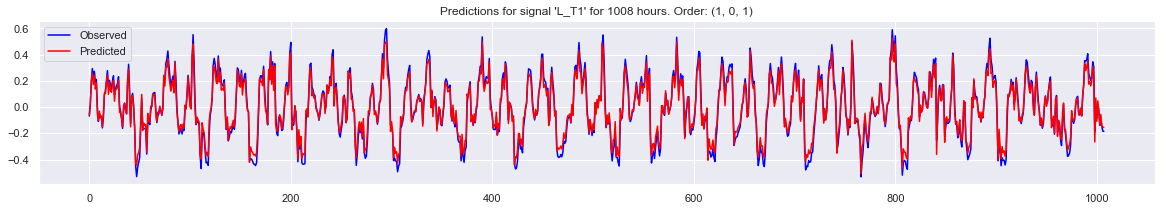

MSE: 0.0019392987605292582
Predicting and plotting prediction for 'L_T2'


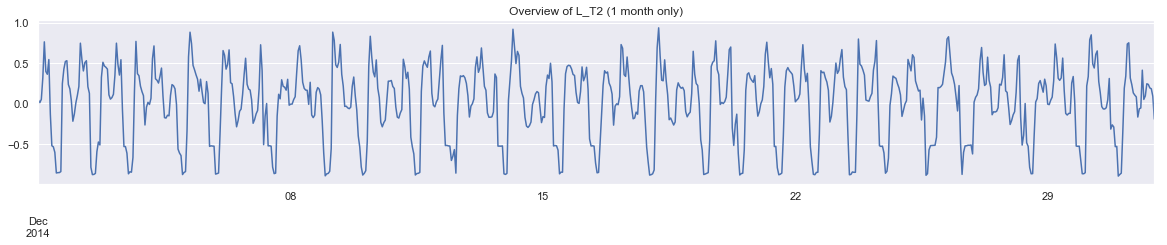

7752 hours used for training, 1008 for testing.


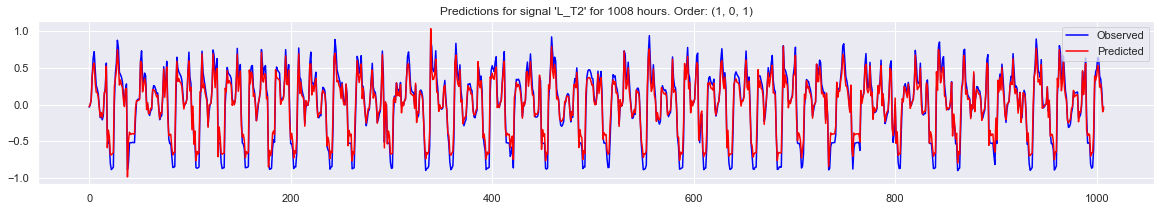

MSE: 0.012757472166867444
Predicting and plotting prediction for 'L_T3'


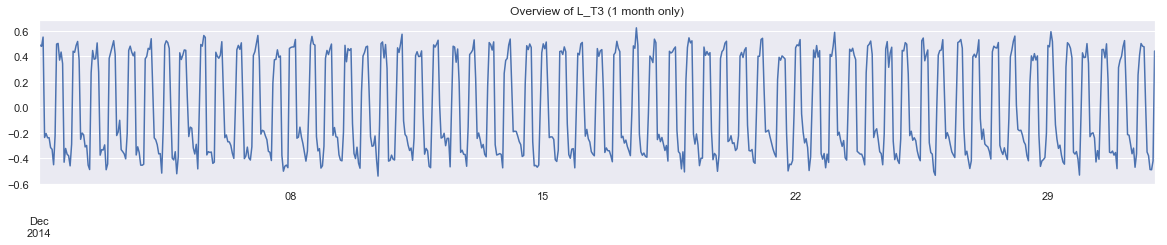

7752 hours used for training, 1008 for testing.


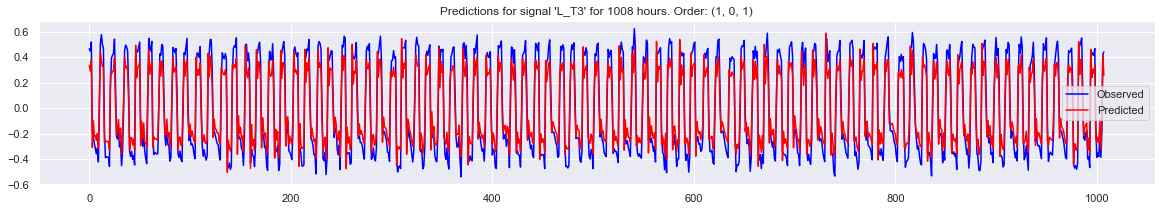

MSE: 0.015402112176214643
Predicting and plotting prediction for 'L_T4'


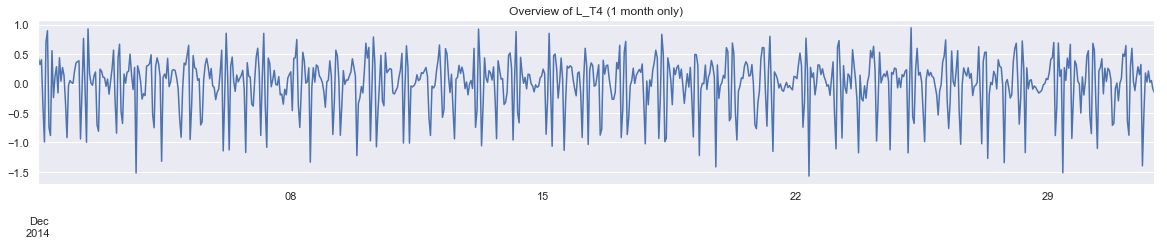

7752 hours used for training, 1008 for testing.


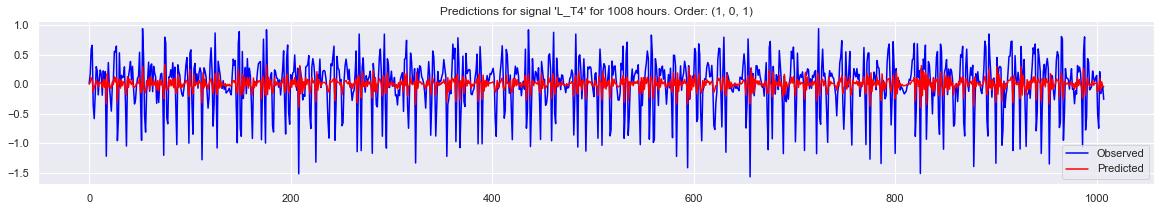

MSE: 0.13888074985234608
Predicting and plotting prediction for 'L_T5'


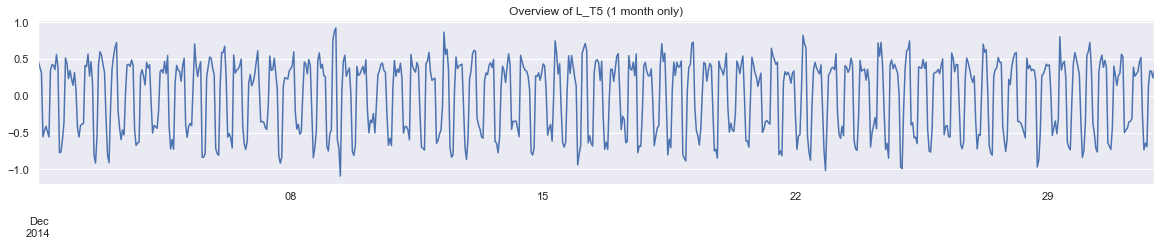

7752 hours used for training, 1008 for testing.


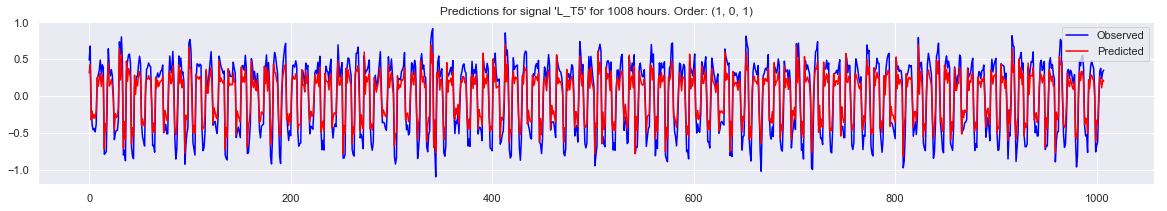

MSE: 0.03774860384084567
Predicting and plotting prediction for 'L_T6'


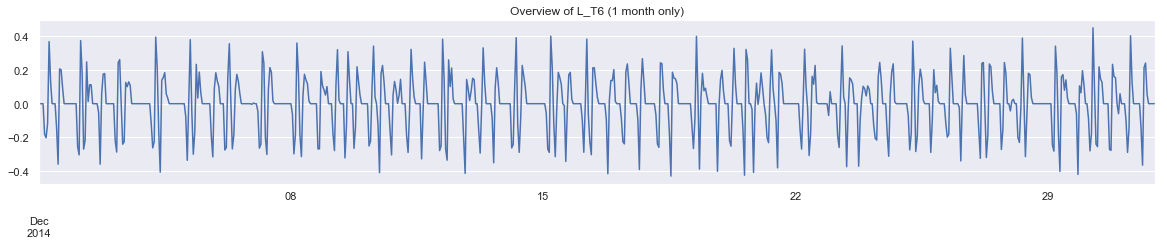

7752 hours used for training, 1008 for testing.


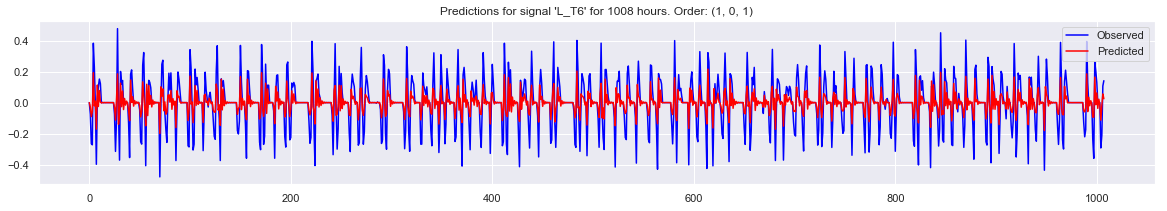

MSE: 0.012711411914091269
Predicting and plotting prediction for 'L_T7'


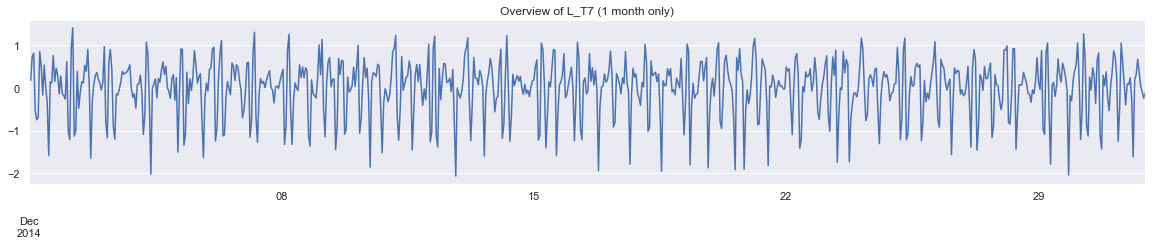

7752 hours used for training, 1008 for testing.


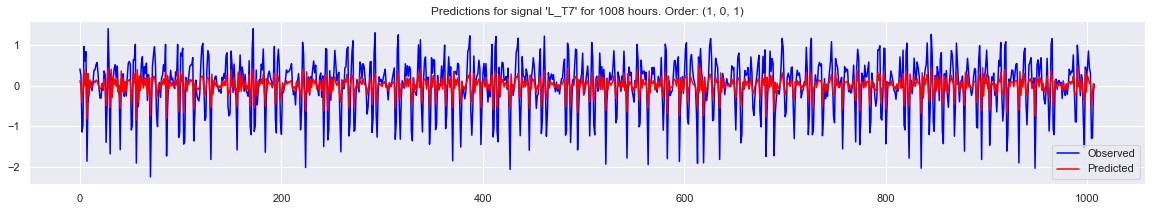

MSE: 0.23812095366612998


In [15]:
for signal in signals.keys():
    print(f"Predicting and plotting prediction for '{signal}'")
    signal_data = signals[signal]
    #print("{} data points for signal '{}'".format(signal_data.shape[0], signal))
    #print(signal_data.head(5))
    
    signal_data.loc['2014-12'].plot(figsize=(20, 3), title=f"Overview of {signal} (1 month only)")
    plt.show()
    
    hours_to_predict = 24 * 7 * 6
    split_point = len(signal_data) - hours_to_predict 

    train = signal_data.iloc[0:split_point]
    test = signal_data.iloc[split_point:]
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions = make_predictions_sarimax(train, test, order)

    plt.figure(figsize=(20,3))
    plt.plot(test.values, color='blue', label='Observed')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f"Predictions for signal '{signal}' for {hours_to_predict} hours. Order: {order}")
    plt.legend()
    plt.show()
    
    print(f"MSE: {mean_squared_error(test.values, predictions)}")

### Thresholding to find anomalies

In [16]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

Let's just look at an overview of the signals we are working with, in the second dataset (we also plot the attack labels)

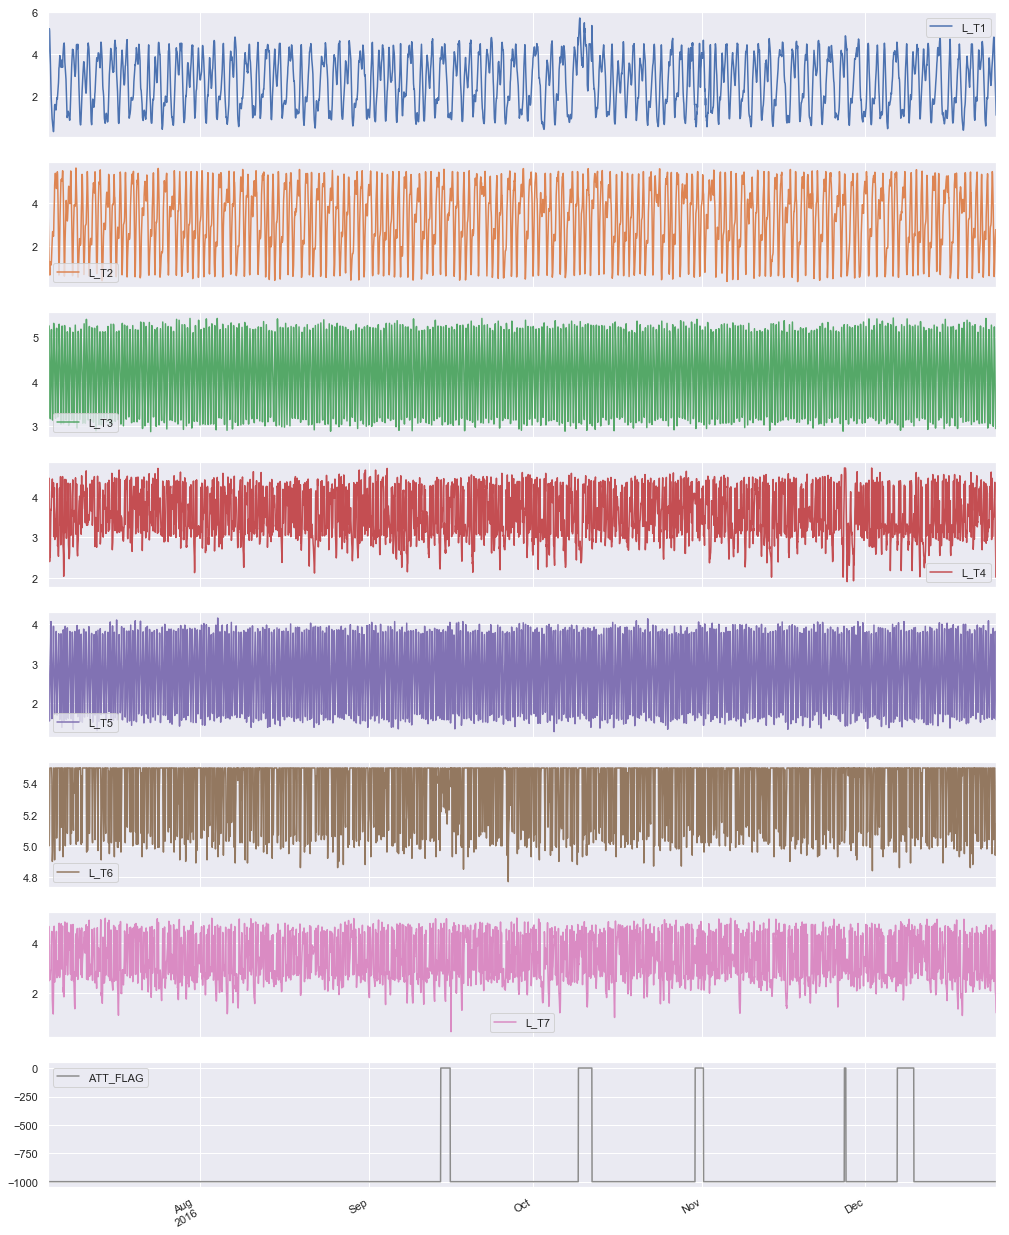

In [17]:
axes = data_trn_2[names + ['ATT_FLAG']].plot(figsize=(17, 3*8), subplots=True) 
plt.show()

In [18]:
test_signals = {}

for name in names:
    series = pd.Series(data_trn_2[name], data_trn_2.index)
    test_signals[name] = series
    display(series.head(5))

2016-07-04 00:00:00    2.44
2016-07-04 01:00:00    2.66
2016-07-04 02:00:00    3.11
2016-07-04 03:00:00    3.62
2016-07-04 04:00:00    4.08
Freq: H, Name: L_T1, dtype: float64

2016-07-04 00:00:00    5.24
2016-07-04 01:00:00    4.53
2016-07-04 02:00:00    3.66
2016-07-04 03:00:00    3.04
2016-07-04 04:00:00    2.68
Freq: H, Name: L_T2, dtype: float64

2016-07-04 00:00:00    3.19
2016-07-04 01:00:00    3.20
2016-07-04 02:00:00    3.66
2016-07-04 03:00:00    4.17
2016-07-04 04:00:00    4.73
Freq: H, Name: L_T3, dtype: float64

2016-07-04 00:00:00    4.10
2016-07-04 01:00:00    4.18
2016-07-04 02:00:00    4.21
2016-07-04 03:00:00    4.04
2016-07-04 04:00:00    3.20
Freq: H, Name: L_T4, dtype: float64

2016-07-04 00:00:00    2.86
2016-07-04 01:00:00    3.29
2016-07-04 02:00:00    3.87
2016-07-04 03:00:00    3.56
2016-07-04 04:00:00    3.11
Freq: H, Name: L_T5, dtype: float64

2016-07-04 00:00:00    5.50
2016-07-04 01:00:00    5.44
2016-07-04 02:00:00    5.15
2016-07-04 03:00:00    4.98
2016-07-04 04:00:00    5.39
Freq: H, Name: L_T6, dtype: float64

2016-07-04 00:00:00    4.39
2016-07-04 01:00:00    4.53
2016-07-04 02:00:00    3.22
2016-07-04 03:00:00    2.40
2016-07-04 04:00:00    3.46
Freq: H, Name: L_T7, dtype: float64



Processing signal 'L_T1'


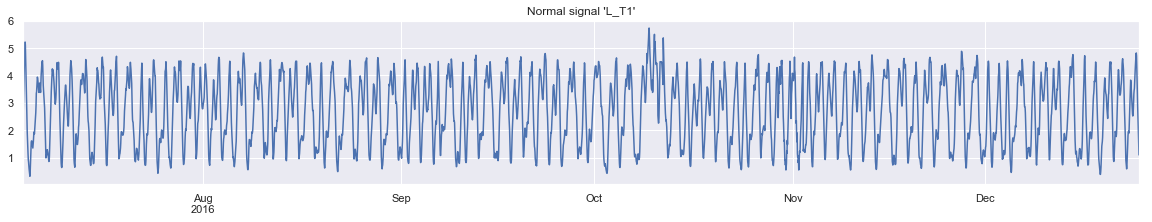

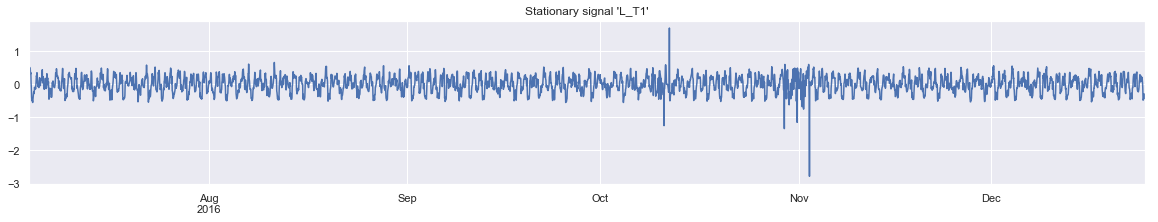



Processing signal 'L_T2'


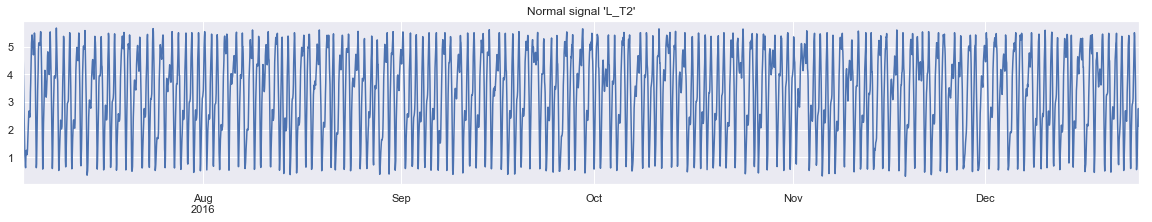

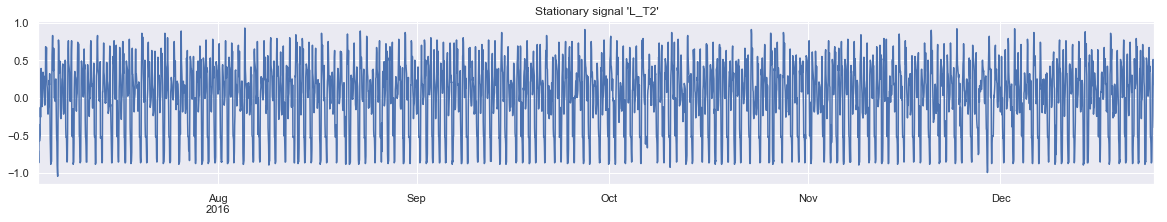



Processing signal 'L_T3'


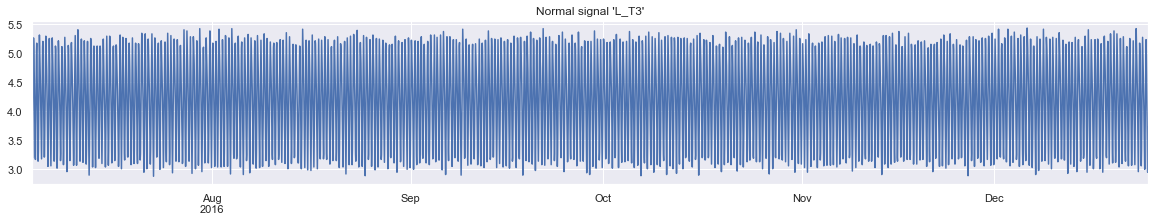

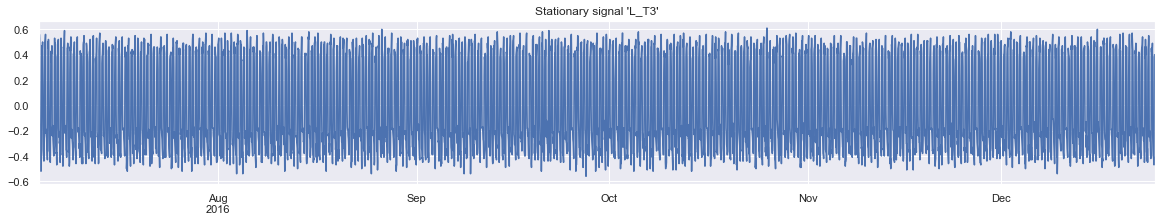



Processing signal 'L_T4'


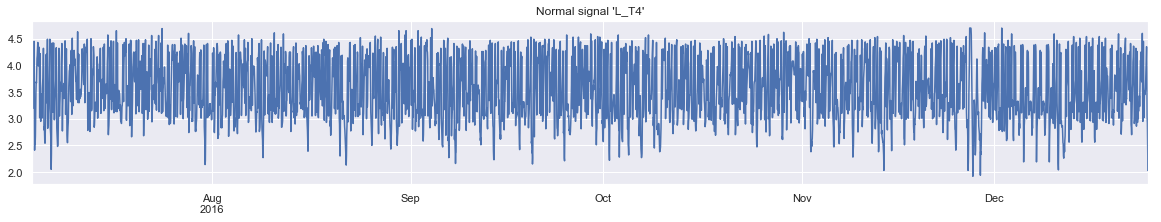

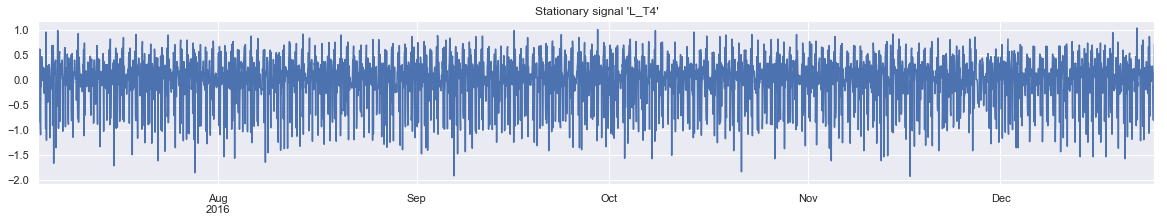



Processing signal 'L_T5'


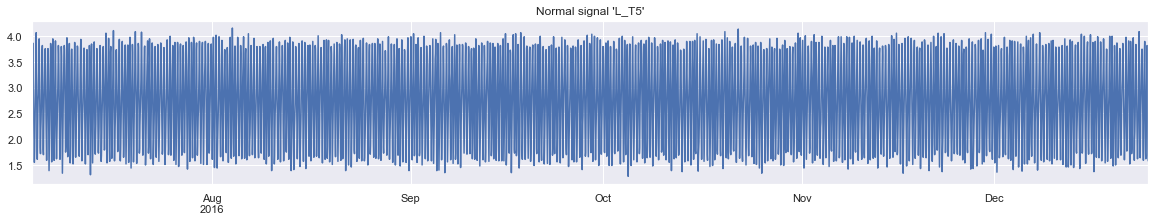

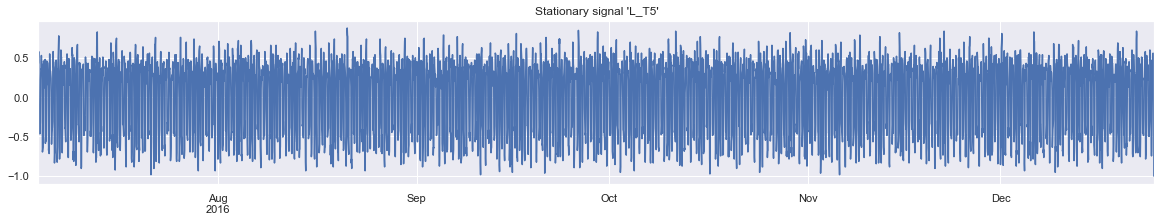



Processing signal 'L_T6'


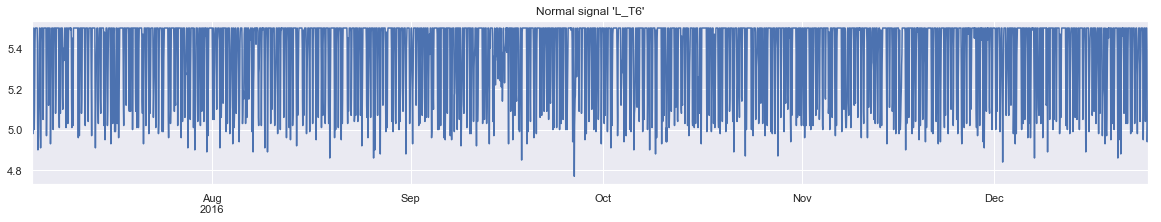

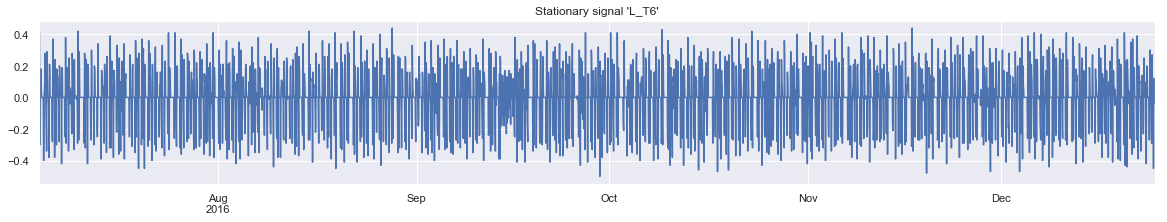



Processing signal 'L_T7'


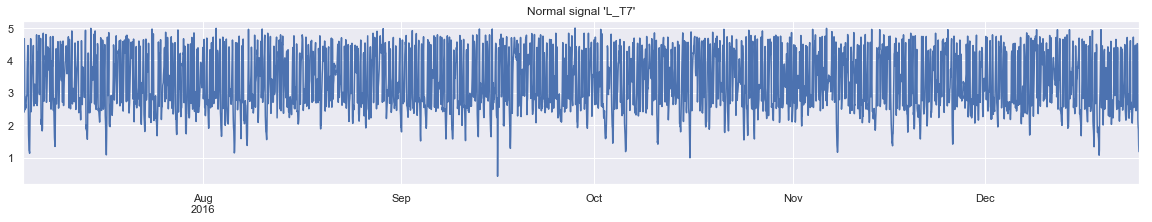

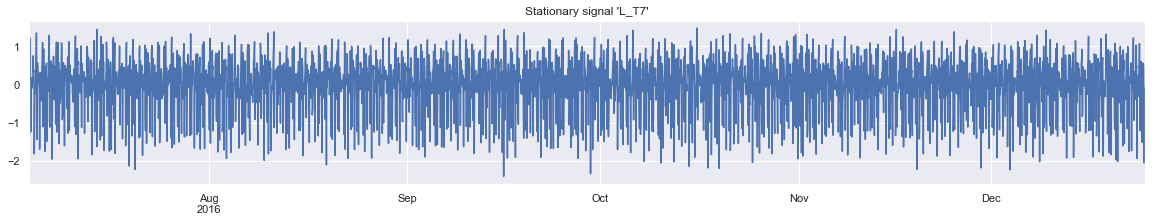

In [19]:
for test_signal in test_signals.keys():
    print(f"\n\nProcessing signal '{test_signal}'")
    
    test_series = test_signals[test_signal]
    
    # visualize it
    test_series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{test_signal}'")
    plt.show()
    
    test_stationary = difference(test_series)

    # visualize it
    test_stationary.plot(figsize=(20,3))
    plt.title(f"Stationary signal '{test_signal}'")
    plt.show()
              
    test_signals[test_signal] = test_stationary

## Predictions!

In [20]:
def make_detection_sarimax(trn_series, tst_series, order, threshold):
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    residuals = []
    start_idx = tst_series.index[0]
    
    for tst_idx in tst_series.index:
        mod_tst = sm.tsa.SARIMAX(tst_series[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        residual = (output.values - tst_series[tst_idx])**2
        residuals.append(residual)
        if residual > threshold:
            # keep predicting on predicted rather than observed (observed is anomalous!)
            tst_series[tst_idx] = output.values
        
    return pd.Series(predictions, tst_series.index), pd.Series(residuals, tst_series.index)

To tune the threshold for the residuals, we use the MSE obtained during training (on normal behaviour) and then we perform grid search on a range of multipliers.

In [21]:
# values obtained during training (dataset 1) on normal behaviour.
mean_squared_errors = {
    'L_T1': 0.0019,
    'L_T2': 0.0128,
    'L_T3': 0.0154,
    'L_T4': 0.1389,
    'L_T5': 0.0377,
    'L_T6': 0.0127,
    'L_T7': 0.2381
}

In [22]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    #print(result.shape[0])
    return result.shape[0]

In [ ]:
thres_multipliers = [1, 1.1, 1.25, 1.5, 2, 2.5, 3, 5, 7, 10, 20, 30, 40, 50, 75]
labels = data_trn_2['ATT_FLAG'].iloc[1:].map({-999:0, 1:1})

for signal in signals.keys():
    f1_best = 0
    threshold_best = 0
    
    print(f"\n------------------------------------\n\nPredicting '{signal}'")
    signal_data = signals[signal]
    test_signal = test_signals[signal]

    train = signal_data
    test = test_signal
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    for mult in thres_multipliers:
        test_copy = test_signal.copy()
        threshold = mult * mean_squared_errors[signal]
        predictions, residuals = make_detection_sarimax(train, test_copy, order, threshold)
        
        detection = pd.DataFrame(np.zeros(test_signal.size), test_signal.index)
        detection[residuals>threshold] = 1
        
        res = pd.concat([labels, detection], axis=1)
        res.columns = ['true', 'pred']
        res.set_index(detection.index)
                
        t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
        t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
        f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
        f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

        try:
            precision = t_p/(t_p + f_p)
        except:
            precision = 0
        
        try:
            recall = t_p/(t_p + f_n)                
        except:
            recall = 0
            
        if (precision + recall ) == 0:
            continue

        f1 = ( 2 * precision * recall ) / (precision + recall )
        
        if f1 > f1_best:
            f1_best = f1
            threshold_best = threshold
            print(f"\nUPDATED. Threshold: {threshold}, Multiplier: {mult}, MSE was {mean_squared_errors[signal]}")
            print(f"TP: {t_p}. FP:{f_p}. TN:{t_n}. FN: {f_n}")
            print(f"Prec: {precision}, Rec: {recall}")
            print(f"f1: {f1}")
    


------------------------------------

Predicting 'L_T1'
8760 hours used for training, 4176 for testing.

UPDATED. Threshold: 0.0019, Multiplier: 1, MSE was 0.0019
TP: 84. FP:1218. TN:2739. FN: 135
Prec: 0.06451612903225806, Rec: 0.3835616438356164
f1: 0.11045364891518737

UPDATED. Threshold: 0.0020900000000000003, Multiplier: 1.1, MSE was 0.0019
TP: 83. FP:1131. TN:2826. FN: 136
Prec: 0.06836902800658978, Rec: 0.3789954337899543
f1: 0.11584089323098394

UPDATED. Threshold: 0.002375, Multiplier: 1.25, MSE was 0.0019
TP: 78. FP:1008. TN:2949. FN: 141
Prec: 0.0718232044198895, Rec: 0.3561643835616438
f1: 0.11954022988505748
